In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from lib.bayes_opt import SamplingOptimizer, RangeOptimizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from matplotlib import pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(precision = 2)
pd.options.display.float_format = '{:,.2f}'.format

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
# x1 ∈ [-5, 10], x2 ∈ [0, 15]
def brannin_hoo(x, e_std=0.01):
    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    e = np.random.normal(0, e_std)
        
    return np.log((x[1] - b * x[0] ** 2 + c * x[0] - r) ** 2 + s * (1 - t) * np.cos(x[0]) + s + e)

brannin_hoo(np.array(np.random.uniform((-5,0),(10,15))), e_std=0.1)

4.5612479287209311

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


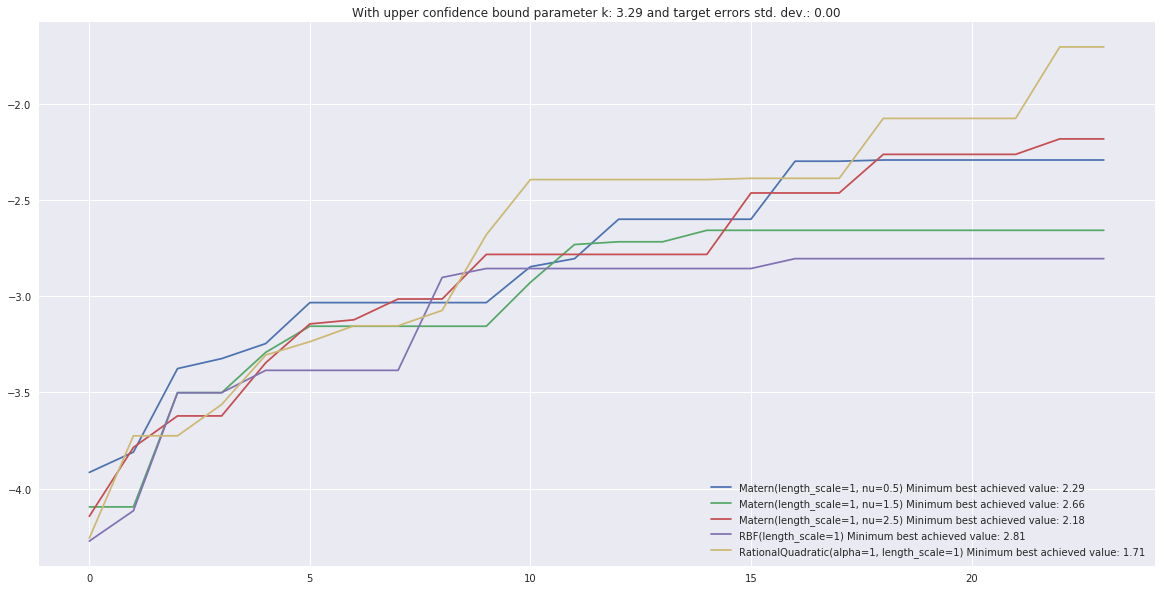

In [22]:
for k in [3.291]:
    for e in [.001]:
        results = []
        for i, kernel in enumerate([Matern(nu=1/2), Matern(nu=3/2), Matern(nu=5/2), RBF(), RationalQuadratic()]):
            all_scores = []
            for r in range(100):
                ro = RangeOptimizer({
                    'x1': (-5., 10.),
                    'x2': (0., 15.)
                }, kernel=kernel, init_observations=[
                    [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                    [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
                ], acquisition_params={
                    'k': k,
                    'type': 'upper_confidence_bound'
                })
                for t in range(25):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
#                 print('Best achieved in this run: {}'.format(-ro.best_achieved[-1]))
                all_scores.append(ro.best_achieved)
                
            avg_scores = np.stack(all_scores, axis=1).min(axis=1)
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Minimum best achieved value: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

## Ensembling Kernels

In [26]:
len(ro.observations)

[autoreload of lib.RangeOptimizer failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named 'BayesianOptimizer'
]


27

[autoreload of lib.RangeOptimizer failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named 'BayesianOptimizer'
]
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.54e-05]), 'nit': 3, 'funcalls': 49, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/

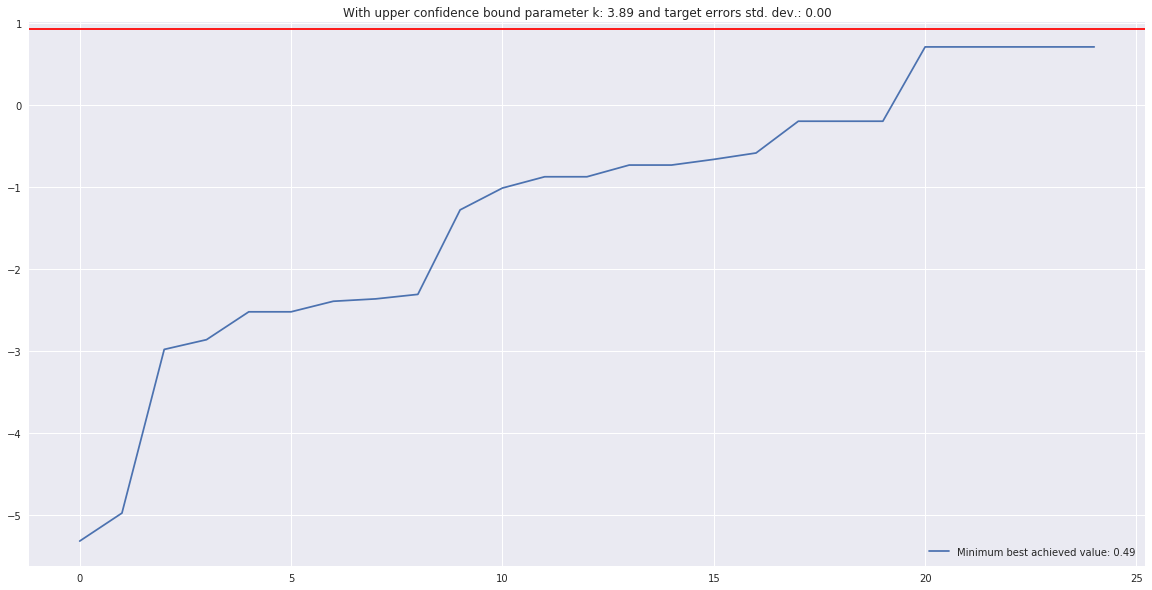

In [25]:
e = .001
k = 3.89
opts = []
all_results = []
for r in range(100):
    results = []
    opts = []
    for kernel in [Matern(nu=1/2), Matern(nu=3/2), Matern(nu=5/2), RBF(), RationalQuadratic()]:
        ro = RangeOptimizer({
            'x1': (-5., 10.),
            'x2': (0., 15.)
        }, kernel=kernel, init_observations=[
            [1, 2, - brannin_hoo(np.array([1, 2]), e_std=e)],
            [0, 0, - brannin_hoo(np.array([0, 0]), e_std=e)]
        ], acquisition_params={
            'k': k,
            'type': 'upper_confidence_bound'
        })
        opts.append(ro)
        
    for t in range(25):
        if t > 5:
            lls = [ro.model.log_marginal_likelihood_value_ for ro in opts]
            best_opt_index = np.argmax(lls)
            x = opts[best_opt_index].suggest(return_dict=True)
        else:
            x = np.random.choice(opts).suggest(return_dict=True)
            
        y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
        results.append(y)
        [ro.update([x[fn] for fn in ro.feature_names], y) for ro in opts]
        results[-1] = np.max([y, np.max(results)])
        
    all_results.append(results)
    
min_results = np.stack(all_results, axis=1).min(axis=1)

plt.figure(figsize=(20,10))
plt.plot(min_results, label='Minimum best achieved value: {:.2f}'.format(np.exp(-np.max(min_results[1:]))))
plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
plt.legend(loc=4)
plt.axhline(- brannin_hoo([9.42478, 2.475]), c='r')
plt.show()

## Wine Example

In [16]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
!head wine.data

--2017-06-27 11:19:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782 (11K) [text/plain]
Saving to: ‘wine.data’

wine.data           100%[===================>]  10.53K  --.-KB/s    in 0s      

2017-06-27 11:19:35 (73.8 MB/s) - ‘wine.data’ saved [10782/10782]

1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,.3,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.5,16.8,113,3.85,3.49,.24,2.18,7.8,.86,3.45,1480
1,13.24,2.59,2.87,21,118,2.8,2.69,.39,1.82,4.32,1.04,2.93,735
1,14.2,1.76,2.45,15.2,112,3.27,3.39,.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.5,2.52,.3,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.6,2.51,.31,1.25

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.]), 'nit': 5, 'funcalls': 54, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.99e-05]), 'nit': 5, 'funcalls': 54, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-package

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.31e-05]), 'nit': 5, 'funcalls': 50, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.28e-05]), 'nit': 6, 'funcalls': 54, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.11e-05]), 'nit': 6, 'funcalls': 50, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally wi

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.66e-05]), 'nit': 6, 'funcalls': 53, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.]), 'nit': 4, 'funcalls': 55, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.]), 'nit': 4, 'funcalls': 51, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state:

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.26e-05]), 'nit': 5, 'funcalls': 54, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  4.52e-01,   1.51e-05]), 'nit': 16, 'funcalls': 64, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.49e-05]), 'nit': 5, 'funcalls': 50, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated 

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.33e-05]), 'nit': 5, 'funcalls': 47, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.18e-05]), 'nit': 4, 'funcalls': 52, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.74e-05]), 'nit': 4, 'funcalls': 54, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally wi

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.43e-05]), 'nit': 4, 'funcalls': 49, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.89e-05]), 'nit': 6, 'funcalls': 57, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.97e-05]), 'nit': 6, 'funcalls': 54, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally wi

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.36e-05]), 'nit': 5, 'funcalls': 52, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -4.78e-05]), 'nit': 5, 'funcalls': 55, 'warnflag': 2}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


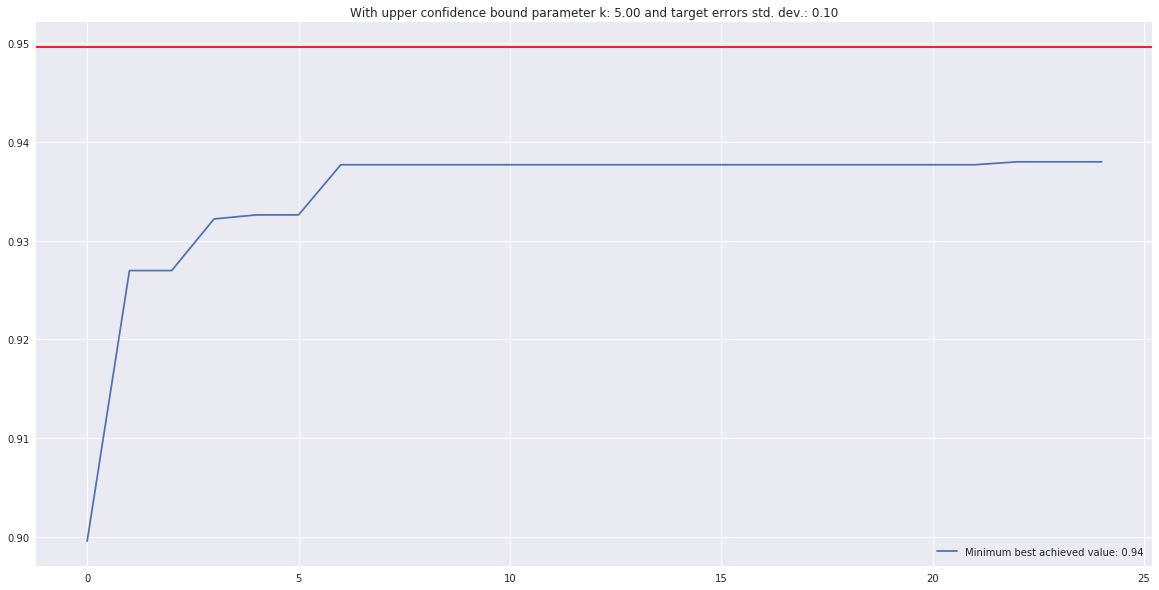

In [24]:
data = pd.read_csv('wine.data', header=None, encoding='utf-8', delimiter=',')
targets = data.iloc[:,0] - 1  # reindex from 0 for XGBoost
features = data.iloc[:,1:]

def cross_validate_xgb(features, targets, params, n_splits=2):
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=23)
    param_names = list(params.keys())
    results = []
    for train, test in k_fold.split(features, targets):
        train_data = xgb.DMatrix(data=features.iloc[train].values,
                                 label=targets.iloc[train].values)
        test_data = xgb.DMatrix(data=features.iloc[test].values,
                                label=targets.iloc[test].values)
        linear_tree_booster = xgb.train(
            params={
                'booster': 'gbtree',
                'objective': 'multi:softmax',
                'num_class': 3,
                **params
            },
            dtrain=train_data,
            num_boost_round=25
        )
        pred = linear_tree_booster.predict(test_data)
        results.append(f1_score(test_data.get_label(), pred, average='weighted'))
        
    return np.mean(results)

e = .1
k = 5
opts = []
all_results = []
for r in range(100):
    results = []
    opts = []
    for kernel in [Matern(nu=1/2), Matern(nu=3/2), Matern(nu=5/2), RBF(), RationalQuadratic()]:
        ro = RangeOptimizer({
            'max_depth': (2, 10),
            'n_estimators': (1, 50),
            'eta': (.01, .9)
        }, kernel=kernel, init_observations=[
            [10, 2, .1, cross_validate_xgb(features, targets, {'max_depth':2, 'n_estimators': 10, 'eta': .1})],
            [10, 2, .5, cross_validate_xgb(features, targets, {'max_depth':2, 'n_estimators': 10, 'eta': .5})]
        ], acquisition_params={
            'k': k,
            'type': 'upper_confidence_bound'
        })
        opts.append(ro)
        
    for t in range(25):
        if t > 5:
            lls = [ro.model.log_marginal_likelihood_value_ for ro in opts]
            best_opt_index = np.argmax(lls)
            x = opts[best_opt_index].suggest(return_dict=True)
        else:
            x = np.random.choice(opts).suggest(return_dict=True)
            
        y = cross_validate_xgb(features, targets, x) # negative to turn mimization into maximization
        results.append(y)
        [ro.update([x[fn] for fn in ro.feature_names], y) for ro in opts]
        results[-1] = np.max([y, np.max(results)])
        
    all_results.append(results)
    
min_results = np.stack(all_results, axis=1).min(axis=1)

plt.figure(figsize=(20,10))
plt.plot(min_results, label='Minimum best achieved value: {:.2f}'.format(np.max(min_results[1:])))
plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
plt.legend(loc=4)
plt.axhline(np.max(all_results), c='r')
plt.show()